In [211]:
#declaramos librebias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.python.framework import ops
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

a=2196 #ponemos semilla
np.random.seed(a)
tf.random.set_seed(a)
a

2196

In [212]:
pd.set_option('display.max_rows', 12) #decimos que muestro solo 12 lineas
DataFrameOrg=pd.read_csv('infarto.csv',delimiter=';') # leemos el csv, y le decimos que el delimitador es: ";"
DataFrameOrg # lo mostramos

,id,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,9046,Masculino,67.0,0,1,Si,Privado,Urbana,228.69,36.6,Ex fumador,1
1,51676,Femenino,61.0,0,0,Si,Autonomo,Rural,202.21,NaN,Nunca,1
2,31112,Masculino,80.0,0,1,Si,Privado,Rural,105.92,32.5,Nunca,1
3,60182,Femenino,49.0,0,0,Si,Privado,Urbana,171.23,34.4,Fumador,1
4,1665,Femenino,79.0,1,0,Si,Autonomo,Rural,174.12,24.0,Nunca,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Femenino,80.0,1,0,Si,Privado,Urbana,83.75,NaN,Nunca,0
5106,44873,Femenino,81.0,0,0,Si,Autonomo,Urbana,125.20,40.0,Nunca,0
5107,19723,Femenino,35.0,0,0,Si,Autonomo,Rural,82.99,30.6,Nunca,0
5108,37544,Masculino,51.0,0,0,Si,Privado,Rural,166.29,25.6,Ex fumador,0


In [213]:
DataFrame=DataFrameOrg.drop(columns=["id"])# eliminaos la columna de ID
DataFrame.isnull().sum() # vemos si alguna columna tiene alguna valor 

genero                    0
edad                      0
hipertensión              0
enfermedad_coronaria      0
casado                    0
trabajo                   0
residencia                0
nivel_glucosa             0
bmi                     201
uso_tabaco                0
infarto                   0
dtype: int64

In [214]:
DataFrameSinNa=DataFrame.dropna().copy() #eliminamos las lineas que tiene el bmi nan
DataFrameSinNa.dtypes # mostramos de que tipo son cada columna

genero                   object
edad                    float64
hipertensión              int64
enfermedad_coronaria      int64
casado                   object
trabajo                  object
residencia               object
nivel_glucosa           float64
bmi                     float64
uso_tabaco               object
infarto                   int64
dtype: object

### Comprobamos los valores cualitativos

In [215]:
DataFrameSinNa['genero'].value_counts() # los de genero

Femenino     2897
Masculino    2011
Other           1
Name: genero, dtype: int64

In [216]:
DataFrameSinNa['casado'].value_counts() # los de casado

Si    3204
No    1705
Name: casado, dtype: int64

In [217]:
DataFrameSinNa['trabajo'].value_counts() # los de trabajo

Privado          2811
Autonomo          775
Menor de edad     671
Funcionario       630
Sin trabajo        22
Name: trabajo, dtype: int64

In [218]:
DataFrameSinNa['residencia'].value_counts()# los de residencia

Urbana    2490
Rural     2419
Name: residencia, dtype: int64

In [219]:
DataFrameSinNa['uso_tabaco'].value_counts()# los del tabaco

Nunca         1852
NSNC          1483
Ex fumador     837
Fumador        737
Name: uso_tabaco, dtype: int64

In [220]:
DNumeric=DataFrameSinNa.copy()
# aqui pasaremos estoas columnas a category
# para convertirlos posteriormente a cuantitativos
DNumeric['genero'] = DNumeric['genero'].astype('category')
DNumeric['casado'] = DNumeric['casado'].astype('category')
DNumeric['trabajo'] = DNumeric['trabajo'].astype('category')
DNumeric['residencia'] = DNumeric['residencia'].astype('category')
DNumeric['uso_tabaco'] = DNumeric['uso_tabaco'].astype('category')

#para optimizar hemos decidido dividir los atributos de edad, bmi, nivel_glucosa en rangos
# estos rangos no han sido arbitrarios, sino que estan basados en rangos osficial
#ej: mas de 30 de bmi, sobreperso
#entre 30 y 24.9 normal ... y asi
#explicado en mas detalle en la memoria.
DNumeric['edad'] = np.select([DNumeric['edad']>=75, DNumeric['edad']>=50,DNumeric['edad']>=25],[1, 2,3], default=4)
DNumeric['bmi'] = np.select([DNumeric['bmi']>=30, DNumeric['bmi']>=24.9,DNumeric['bmi']>=18.5],[0, 1,2], default=3)
DNumeric['nivel_glucosa'] = np.select([DNumeric['nivel_glucosa']>=200, DNumeric['nivel_glucosa']>=150],[0, 1], default=2)
DNumeric

,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,Masculino,2,0,1,Si,Privado,Urbana,0,0,Ex fumador,1
2,Masculino,1,0,1,Si,Privado,Rural,2,0,Nunca,1
3,Femenino,3,0,0,Si,Privado,Urbana,1,0,Fumador,1
4,Femenino,1,1,0,Si,Autonomo,Rural,1,2,Nunca,1
5,Masculino,1,0,0,Si,Privado,Urbana,1,1,Ex fumador,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Femenino,4,0,0,No,Menor de edad,Rural,2,2,NSNC,0
5106,Femenino,1,0,0,Si,Autonomo,Urbana,2,0,Nunca,0
5107,Femenino,3,0,0,Si,Autonomo,Rural,2,0,Nunca,0
5108,Masculino,2,0,0,Si,Privado,Rural,1,1,Ex fumador,0


In [221]:
DNumeric["genero"] = DNumeric["genero"].cat.codes
DNumeric["casado"] = DNumeric["casado"].cat.codes
DNumeric["trabajo"] = DNumeric["trabajo"].cat.codes
DNumeric["residencia"] = DNumeric["residencia"].cat.codes
DNumeric["uso_tabaco"] = DNumeric["uso_tabaco"].cat.codes

#DNumeric=DNumeric.drop(columns=["residencia"])


In [222]:
numeroinfartos=DataFrameSinNa['infarto'].value_counts()[1]
numeroinfartos# extramoes el nuemro de infartos que tenemos

209

In [223]:
Dseparacion=DNumeric.copy()
y=Dseparacion.infarto
Dseparacion=Dseparacion.drop(columns=["infarto"]) # eliminamos la columna infarto
y = np.array(y)
Ytotales=y.reshape(y.shape[0],1)# cambiamos la dimension de (X,) a (X,1)
Ytotales # extramos la columa de infarto

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [224]:
x = Dseparacion.values #returns a numpy array
scaler = preprocessing.MinMaxScaler() #hacemos la normalizacion de los datos
Xtotales = scaler.fit_transform(x)
Xtotales #mostramos los datos

array([[0.5       , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.66666667, 0.        , ..., 0.5       , 0.        ,
        0.33333333],
       ...,
       [0.        , 0.66666667, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.5       , 0.33333333, 0.        , ..., 0.5       , 0.33333333,
        0.        ],
       [0.        , 0.66666667, 0.        , ..., 1.        , 0.33333333,
        0.66666667]])

In [225]:
# aqui lo que haremos es asegurarnos, que la mayoria de los infartos vayan para train
Xinfartos=Xtotales[:numeroinfartos] # extraemos los infartos 
Yinfartos=Ytotales[:numeroinfartos]
#damos el 10% a test
Xinfartos, X_test0, Yinfartos, Y_test0 = train_test_split(Xinfartos,Yinfartos, test_size=0.1,random_state=42)
#damos el 10% a validation del resto
Xinfartos, X_validation0, Yinfartos, Y_validation0 = train_test_split(Xinfartos,Yinfartos, test_size=0.1,random_state=42)

#nos quedamos con los que no le han dado infarto
XtotalesSinInfartos=Xtotales[numeroinfartos:]
YtotalesSinInfartos=Ytotales[numeroinfartos:]

In [226]:
# de los que no hay infarto damos un 15% a test
X, X_test, Y, Y_test = train_test_split(XtotalesSinInfartos,YtotalesSinInfartos, test_size=0.15,random_state=42)
# ahora del train quitamos un 15% para validation
X, X_validation, Y, Y_validation = train_test_split(X,Y, test_size=0.15,random_state=42)

#unimos los infartos con los no infartos, tanto para el train, como para el validation, como para el test
X = np.concatenate((Xinfartos, X))
Y = np.concatenate((Yinfartos, Y))

X_test = np.concatenate((X_test0, X_test))
Y_test = np.concatenate((Y_test0, Y_test))

X_validation = np.concatenate((X_validation0, X_validation))
Y_validation = np.concatenate((Y_validation0, Y_validation))

In [227]:
model=Sequential() #sequencial fully-conected

In [228]:
#definimos las capas y las neuronas de cada capa.
model.add(Dense(165,input_dim=Dseparacion.shape[1],activation='relu')) # capa de entra y capa ocula
model.add(Dense(55, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # salida

In [229]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])# poneoms de optimizador ="adam"

In [230]:
hist=model.fit(X, Y,batch_size=32,validation_data=(X_validation,Y_validation), epochs=35)

Epoch 1/35
112/112 [==============================] - 0s 3ms/step - loss: 0.0624 - accuracy: 0.9430 - val_loss: 0.0294 - val_accuracy: 0.9693
Epoch 2/35
112/112 [==============================] - 0s 1ms/step - loss: 0.0426 - accuracy: 0.9526 - val_loss: 0.0313 - val_accuracy: 0.9693
Epoch 3/35
112/112 [==============================] - 0s 1ms/step - loss: 0.0417 - accuracy: 0.9526 - val_loss: 0.0297 - val_accuracy: 0.9693
Epoch 4/35
112/112 [==============================] - 0s 1ms/step - loss: 0.0410 - accuracy: 0.9526 - val_loss: 0.0300 - val_accuracy: 0.9693
Epoch 5/35
112/112 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9526 - val_loss: 0.0314 - val_accuracy: 0.9693
Epoch 6/35
112/112 [==============================] - 0s 2ms/step - loss: 0.0405 - accuracy: 0.9526 - val_loss: 0.0311 - val_accuracy: 0.9693
Epoch 7/35
112/112 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 0.9526 - val_loss: 0.0324 - val_accuracy: 0.9693
Epoch 

In [231]:
model.evaluate(X, Y) # del train

112/112 [==============================] - 0s 1ms/step - loss: 0.0301 - accuracy: 0.9655


[0.030083337798714638, 0.9654881954193115]

In [232]:
model.evaluate(X_validation, Y_validation) # del validation

20/20 [==============================] - 0s 1ms/step - loss: 0.0394 - accuracy: 0.9580


[0.039445243775844574, 0.9579967856407166]

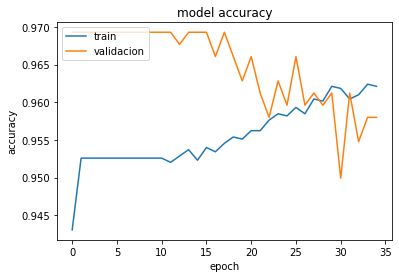

In [233]:
#representamos el model accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy') # eje y
plt.xlabel('epoch') # eje x
plt.legend(['train', 'validacion'], loc='upper left') # ponemos la leyenda
plt.show() # lo mostramos


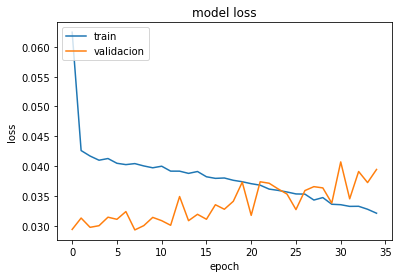

In [234]:
#representamos el model loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss') # titulo
plt.ylabel('loss') # eje y
plt.xlabel('epoch') # eje x
plt.legend(['train', 'validacion'], loc='upper left') # leyenda
plt.show() # lo mostramos

### Confusion matrix Total de datos

[[  53  156]
 [  21 4679]]


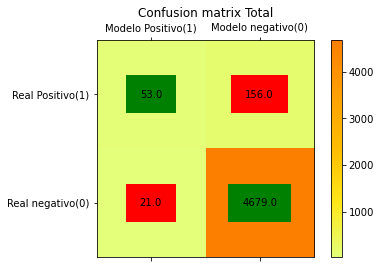

In [235]:
YpredictT=model(Xtotales) # las predictiones para los datos
YpredictT=YpredictT.numpy() # los pasamos a numpy
YpredictT=YpredictT.round() # los redondeamos
YpredictT = YpredictT.astype(np.int64) # los ponemos tipo integer

#sacamos la matriz de confusion
labl=[1,0]
matrix = confusion_matrix(Ytotales.flatten(), YpredictT.flatten(),labels=labl)

print(matrix) # imprimimos la matriz
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix,cmap='Wistia')#Establecemos los colores
plt.title('Confusion matrix Total') # ponemos los titulos

#fig.colorbar(cax)
ax.set_xticks(labl)
ax.set_yticks(labl)
ax.set_xticklabels(['Modelo negativo(0)','Modelo Positivo(1)'])
ax.set_yticklabels(['Real negativo(0)','Real Positivo(1)'])
plt.colorbar(cax) # enseñamos la barra de colores

# esto lo hacemos para poner en cada cuadrado el nuemro correspondiente y el color verde o rojo
for (i, j), z in np.ndenumerate(matrix): # recorremos la matriz
    t=ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    if i ==j: #si es 0,0 o 1,1 enotnces poneos el color verde
        t.set_bbox(dict(facecolor='green', edgecolor='green' ,linewidth=20))
    else: # sino ponemos el rojo
        t.set_bbox(dict(facecolor='red', edgecolor='red' ,linewidth=20))

plt.show() #lo mostramos

### Confusion matrix datos de prueba

[[  2  19]
 [  9 696]]


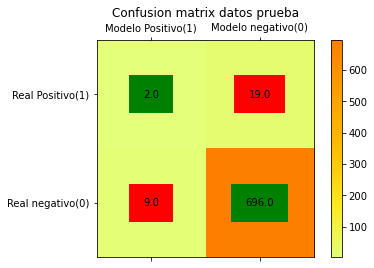

In [236]:
Ypredict=model(X_test) # las predictiones para los datos
Ypredict=Ypredict.numpy() # los pasamos a numpy
Ypredict=Ypredict.round() # los redondeamos
Ypredict = Ypredict.astype(np.int64) # los ponemos tipo integer

#sacamos la matriz de confusion
labl=[1,0]
matrix = confusion_matrix(Y_test.flatten(), Ypredict.flatten(),labels=labl)

print(matrix) # imprimimos la matriz
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix,cmap='Wistia')#Establecemos los colores
plt.title('Confusion matrix datos prueba') # ponemos los titulos

#fig.colorbar(cax)
ax.set_xticks(labl)
ax.set_yticks(labl)
ax.set_xticklabels(['Modelo negativo(0)','Modelo Positivo(1)'])
ax.set_yticklabels(['Real negativo(0)','Real Positivo(1)'])
plt.colorbar(cax) # enseñamos la barra de colores

# esto lo hacemos para poner en cada cuadrado el nuemro correspondiente y el color verde o rojo
for (i, j), z in np.ndenumerate(matrix): # recorremos la matriz
    t=ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    if i ==j: #si es 0,0 o 1,1 enotnces poneos el color verde
        t.set_bbox(dict(facecolor='green', edgecolor='green' ,linewidth=20))
    else: # sino ponemos el rojo
        t.set_bbox(dict(facecolor='red', edgecolor='red' ,linewidth=20))

plt.show() #lo mostramos

![title](a.png)

### Test

In [237]:
print("precision test:" + str(precision_score(Y_test, Ypredict))) # sacamos la precision
print("recall test:" + str(recall_score(Y_test, Ypredict))) # sacamos el recall
print("accuracy test:" + str(accuracy_score(Y_test, Ypredict))) # sacamos el accuracy


precision test:0.18181818181818182
recall test:0.09523809523809523
accuracy test:0.9614325068870524


### Totales

In [238]:
print("precision total:" + str(precision_score(Ytotales, YpredictT)))  # sacamos la precision
print("recall total:" + str(recall_score(Ytotales, YpredictT)))  # sacamos el recall
print("accuracy total:" + str(accuracy_score(Ytotales, YpredictT))) # sacamos el accuracy

precision total:0.7162162162162162
recall total:0.2535885167464115
accuracy total:0.9639437767366063


### Que caracteristica influye mas o menos

In [239]:
#sacamos la media de los pesos conectados a cada entrada, para saber cual de ellas influyen mas
temp=abs(model.get_weights()[0])
for index,x in enumerate(temp):
    print(Dseparacion.columns[index]) #imprimimos el nombre de cada entrada
    print(x.mean()) # imprimimos la media

genero
0.13379514
edad
0.14631346
hipertensión
0.09800337
enfermedad_coronaria
0.09702198
casado
0.10366627
trabajo
0.11630464
residencia
0.103384085
nivel_glucosa
0.13325961
bmi
0.15152863
uso_tabaco
0.115261935
